# Libraries

In [1]:
import numpy as np
import numpy.linalg as linalg
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
from pyhull.delaunay import DelaunayTri

# My Libraries


In [2]:
from libraries.Spectrum import *
from libraries.MyPlot import *
import libraries.MyMath as mm

# Initial Data

In [3]:
start_wave = 400
end_wave = 700
data_size = 31
distance = (end_wave - start_wave) / (data_size - 1)

blue_sample_num = 7
yellow_sample_num = 7
red_sample_num = 7

maxRMS = 0.001
precise = 6
"""
Creating Wave lengths array for plots
Creating Example Data for checking plots
"""
# [400, 410, 420, ..., 700]
wave_length = mm.array_distance(400, distance, 700)

# [1, 1, 1, ..., 1]
example_data = mm.array_repeat(1, data_size)

"""
Start Getting Data From Excel file
"""
data = pd.read_excel("data/data.xls")

extract_data = pd.DataFrame(data, columns=["c"])
c = extract_data.to_numpy()
c = mm.cleanNaN(c)

R_red = []
for i in range(1, red_sample_num + 1):
    extract_data = pd.DataFrame(data, columns=["r" + str(i)])
    R_red.append(extract_data.to_numpy())

R_yellow = []
for i in range(1, yellow_sample_num + 1):
    extract_data = pd.DataFrame(data, columns=["y" + str(i)])
    R_yellow.append(extract_data.to_numpy())

R_blue = []
for i in range(1, blue_sample_num + 1):
    extract_data = pd.DataFrame(data, columns=["b" + str(i)])
    R_blue.append(extract_data.to_numpy())


extract_data = pd.DataFrame(data, columns=["Rsub"])
R_sub = extract_data.to_numpy()
k_sub = mm.applyFunction(R_sub, find_KOVERS)

extract_data = pd.DataFrame(data, columns=["Rstd"])
R_std = extract_data.to_numpy()
k_std = mm.applyFunction(R_std, find_KOVERS)

extract_data = pd.DataFrame(data, columns=["xbar"])
xbar = extract_data.to_numpy()

extract_data = pd.DataFrame(data, columns=["ybar"])
ybar = extract_data.to_numpy()

extract_data = pd.DataFrame(data, columns=["zbar"])
zbar = extract_data.to_numpy()

viewer = Viewer(xbar, ybar, zbar)

extract_data = pd.DataFrame(data, columns=["D65"])
E_D65 = extract_data.to_numpy()
light_source = LightSource(E_D65)

munsell_size = 1269
munsell_R = []
data = pd.read_excel("data/Munsell400_10_700.xlsx")
for i in range(munsell_size):
    newdata = data[data.columns[i]]
    newdata = newdata.to_numpy()
    # newdata = np.array([newdata])
    munsell_R.append(newdata)
munsell_R = np.array(munsell_R).T

munsell_A = np.cov(munsell_R)
print(munsell_A.shape)
eigenValues, eigenVectors = linalg.eig(munsell_A)
idx = eigenValues.argsort()[::-1]
eigenValues = eigenValues[idx]
eigenVectors = eigenVectors[:, idx]

print(eigenVectors)
print(eigenVectors[0:3].shape)

(31, 31)
[[ 9.48337330e-02 -1.15706432e-01  1.57671450e-01  1.35023433e-01
   4.22755300e-02  1.53755334e-02  6.87051862e-01  1.65060110e-01
  -5.20889941e-01  2.10782481e-01  4.80351254e-02 -7.75282952e-02
  -1.95570897e-01 -7.68911157e-02 -6.91027041e-02  2.13923129e-01
   1.08834108e-01 -2.84245420e-02 -7.42043397e-03 -9.44697572e-03
  -1.15843315e-02  1.21962832e-02 -2.10442141e-02  3.48476968e-03
   1.50492571e-02  1.14911399e-03 -1.21233980e-02  1.79018312e-02
  -4.52232092e-03  9.73034988e-03  1.00339508e-02]
 [ 1.35347498e-01 -1.75450232e-01  2.26715222e-01  1.73014111e-01
   1.16781826e-01 -2.45244529e-02  3.51241837e-01  2.46697190e-03
   8.13782544e-02 -1.30647508e-01  1.07802750e-02  1.47964215e-01
   2.58357489e-01  1.58182544e-01  2.02036340e-01 -6.31192295e-01
  -3.21254629e-01  1.05580920e-01  5.22483050e-02  3.05285839e-02
   7.83355601e-02 -3.58998972e-02  6.55364916e-02 -1.26354387e-02
  -5.51998734e-02  3.30876593e-02  8.36790662e-02 -9.46142175e-02
   2.46363387e-0

# K OVER S for dyes

In [4]:
# initial object to find K OVER S for Blue Dye
BBB = Dye(blue_sample_num, data_size)
BBB.setR(R_blue)
BBB.setC(c)
BBB.setSub(R_sub)


# initial object to find K OVER S for Red Dye
RRR = Dye(red_sample_num, data_size)
RRR.setR(R_red)
RRR.setC(c)
RRR.setSub(R_sub)


# initial object to find K OVER S for Yellow Dye
YYY = Dye(yellow_sample_num, data_size)
YYY.setR(R_yellow)
YYY.setC(c)
YYY.setSub(R_sub)

blue_KOVERS = BBB.getKOVERS()
red_KOVERS = RRR.getKOVERS()
yellow_KOVERS = YYY.getKOVERS()

# Method 1 Spectrophotometric Matching

In [5]:
all_KOVERS = np.hstack((blue_KOVERS, red_KOVERS, yellow_KOVERS))
delta_KOVERS = mm.sum([k_std, -1 * k_sub])
C_First = findC1(all_KOVERS, delta_KOVERS)


First = Mixture(R_sub)
First.add(C_First[0], blue_KOVERS)
First.add(C_First[1], red_KOVERS)
First.add(C_First[2], yellow_KOVERS)
KOVERS_First = First.getKOVERS()
R_First = First.getR()

EST = Observation(light_source, viewer, R_First)
STD = Observation(light_source, viewer, R_std)
compare_1 = Compare(EST, STD)
RMS_First = compare_1.RMS()
DeltaE_First = compare_1.delta_E()

# Method 2 Colorimetric Matching

In [6]:
Data3 = findC2(STD, R_sub, C_First, all_KOVERS, maxRMS)
C_Last = Data3[0]
all_E = Data3[1]
num_tried = Data3[2]


Last = Mixture(R_sub)
Last.add(C_Last[0], blue_KOVERS)
Last.add(C_Last[1], red_KOVERS)
Last.add(C_Last[2], yellow_KOVERS)
KOVERS_Last = Last.getKOVERS()
R_Last = Last.getR()

ESTN = Observation(light_source, viewer, R_Last)
compare_2 = Compare(STD, ESTN)
RMS_Last = compare_2.RMS()
DeltaE_Last = compare_2.delta_E()

# SET R Substrate to 1

In [7]:
R_sub = np.array([mm.array_repeat(1, data_size)]).T

# Method 3 Interpolation using XYZ

In [8]:
pr = 10
Dis1 = np.linspace(0 * C_First[0], 1, pr)
Dis2 = np.linspace(0 * C_First[1], 1, pr)
Dis3 = np.linspace(0 * C_First[2], 1, pr)

XYZ_Lookup = []
C_Lookup = []

Mix = Mixture(R_sub)
for x in range(pr):
    for y in range(pr):
        for z in range(pr):
            Mix.clear()
            Mix.add(Dis1[x][0], blue_KOVERS)
            Mix.add(Dis2[y][0], red_KOVERS)
            Mix.add(Dis3[z][0], yellow_KOVERS)
            Temp = Observation(light_source, viewer, Mix.getR())
            XYZ_Lookup.append([Temp.getX(), Temp.getY(), Temp.getZ()])
            C_Lookup.append([Dis1[x][0], Dis2[y][0], Dis3[z][0]])

XYZ_Lookup = np.array(XYZ_Lookup)
C_Lookup = np.array(C_Lookup)

Temp = Observation(light_source, viewer, R_std)
Find = [Temp.getX(), Temp.getY(), Temp.getZ()]
calc = MyDelaunay(XYZ_Lookup)
res = calc.getResult(Find, C_Lookup)
C_Inter1 = res[0]

Mix.clear()
Mix.add(C_Inter1[0], blue_KOVERS)
Mix.add(C_Inter1[1], red_KOVERS)
Mix.add(C_Inter1[2], yellow_KOVERS)
R_Inter1 = Mix.getR()
Inter1 = Observation(light_source, viewer, Mix.getR())
STD = Observation(light_source, viewer, R_std)
compare_3 = Compare(Inter1, STD)
RMS_Inter1 = compare_3.RMS()
DeltaE_Inter1 = compare_3.delta_E()

print(C_Inter1)
print(RMS_Inter1)
print(DeltaE_Inter1)

[0.23420132 0.27092521 0.0280852 ]
0.2450273841718568
3.7231107982639418


# Method 4 Interpolation using R Principal Component 3D

[0.11111111 0.21893821 0.12018927]
0.24728828616985385


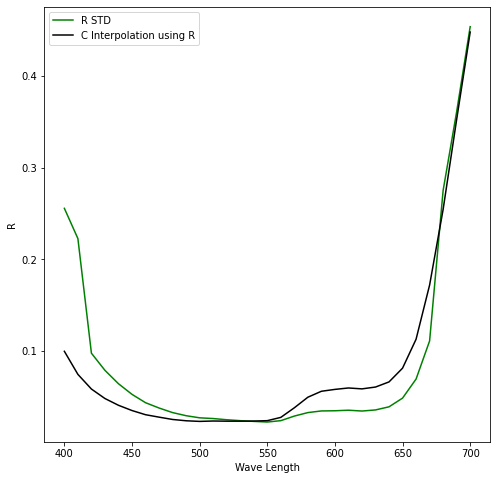

In [9]:
# Number of points
pr = 10

# Number of times to reduce dimension
dim = 3  # 3D

Dis1 = np.linspace(0, 1, pr)
Dis2 = np.linspace(0, 1, pr)
Dis3 = np.linspace(0, 1, pr)

R_Lookup = []
C_Lookup = []

Mix = Mixture(R_sub)
for x in range(pr):
    for y in range(pr):
        for z in range(pr):
            Mix.clear()
            Mix.add(Dis1[x], blue_KOVERS)
            Mix.add(Dis2[y], red_KOVERS)
            Mix.add(Dis3[z], yellow_KOVERS)
            R_Lookup.append(Mix.getR().T[0])
            C_Lookup.append([Dis1[x], Dis2[y], Dis3[z]])

R_Lookup = R_Lookup
R_Lookup = np.array(R_Lookup)
R_Lookup = mm.array_PC(R_Lookup, dim, eigenVectors)
# print(R_Lookup.shape)

C_Lookup = np.array(C_Lookup)
calc = MyDelaunay(R_Lookup, "Qt")

# Changing R_std
# R_std = np.array([munsell_R.T[55]]).T

# Finding
R_Find = R_std.T[0]
R_Find = mm.PC(R_Find, dim, eigenVectors)
res = calc.getResult(R_Find, C_Lookup)
C_Inter2 = res[0]

Mix.clear()
Mix.add(C_Inter2[0], blue_KOVERS)
Mix.add(C_Inter2[1], red_KOVERS)
Mix.add(C_Inter2[2], yellow_KOVERS)
R_Inter2 = Mix.getR()
Inter2 = Observation(light_source, viewer, Mix.getR())
STD = Observation(light_source, viewer, R_std)
compare_4 = Compare(Inter2, STD)
RMS_Inter2 = compare_4.RMS()
DeltaE_Inter2 = compare_4.delta_E()

print(C_Inter2)
print(RMS_Inter2)

(p1,) = plt.plot(wave_length, R_std, color="green", label="R STD")
(p2,) = plt.plot(wave_length, R_Inter2, color="black", label="C Interpolation using R")
lines = [p1, p2]
plt.legend(lines, [l.get_label() for l in lines])
plt.gcf().canvas.set_window_title("Comparison")
plt.xlabel("Wave Length")
plt.ylabel("R")
plt.gcf().set_size_inches(8, 8)
plt.show()

# Showing Results

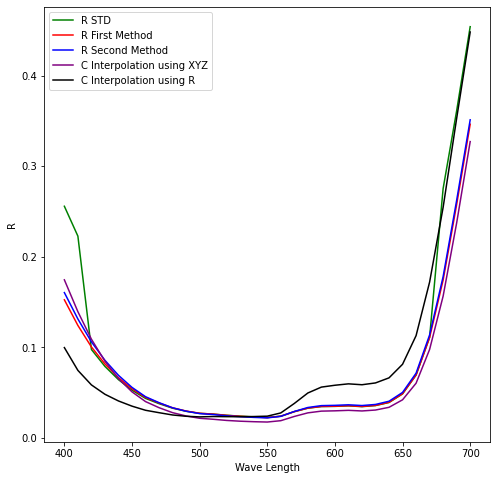

In [10]:
(p1,) = plt.plot(wave_length, R_std, color="green", label="R STD")
(p2,) = plt.plot(wave_length, R_First, color="red", label="R First Method")
(p3,) = plt.plot(wave_length, R_Last, color="blue", label="R Second Method")
(p4,) = plt.plot(
    wave_length, R_Inter1, color="purple", label="C Interpolation using XYZ"
)
(p5,) = plt.plot(wave_length, R_Inter2, color="black", label="C Interpolation using R")
# p6, = plt.plot(wave_length, R_sub, color='yellow', label="R SUB")
lines = [p1, p2, p3, p4, p5]
plt.legend(lines, [l.get_label() for l in lines])
plt.gcf().canvas.set_window_title("Comparison")
plt.xlabel("Wave Length")
plt.ylabel("R")
plt.gcf().set_size_inches(8, 8)
plt.show()

# Try Method 4 for different spectrum

[0.01118476 0.01593033 0.01918734]
2.3769285392694375


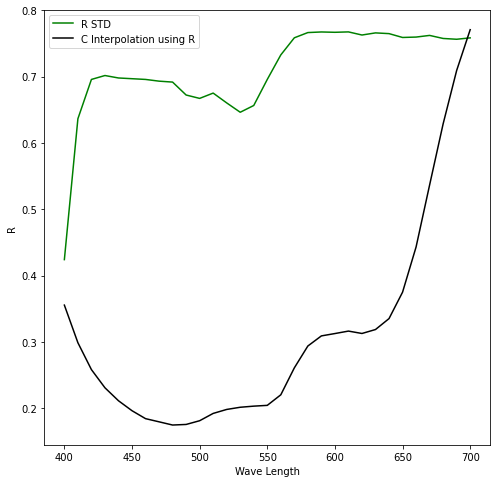

[0.03405374 0.01949384 0.02383752]
1.8829614508307921


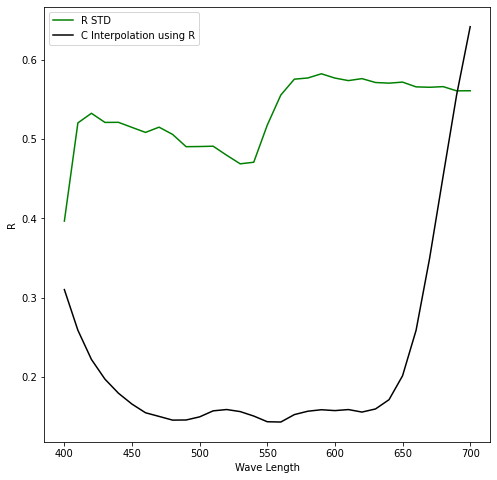

[0.0589039  0.02373648 0.02236707]
1.3373273815896403


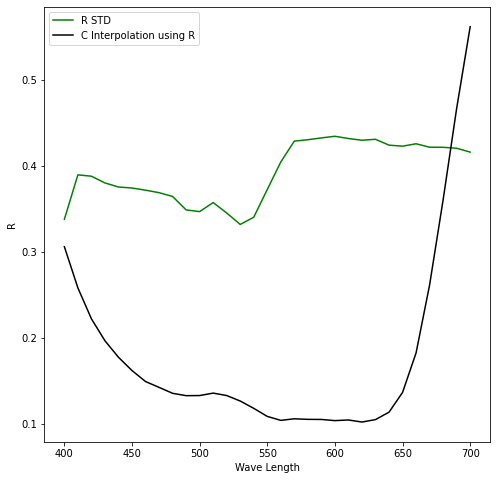

[0.21840908 0.01515621 0.01886712]
1.003389206811925


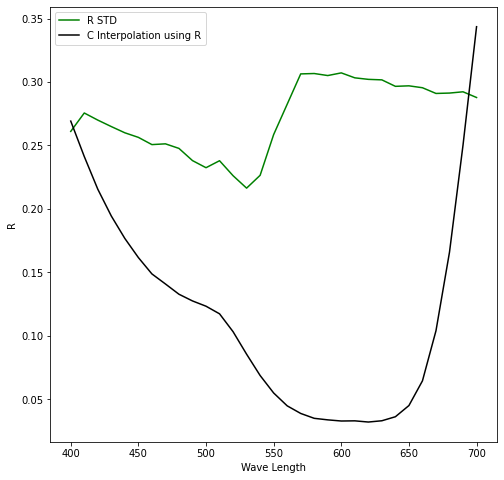

[0.1579505  0.11066487 0.00044624]
0.6818596686940115


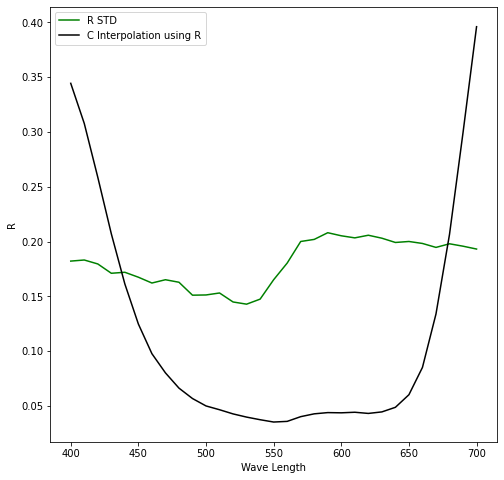

[0.81930826 0.11061396 0.00389214]
0.4903083172530746


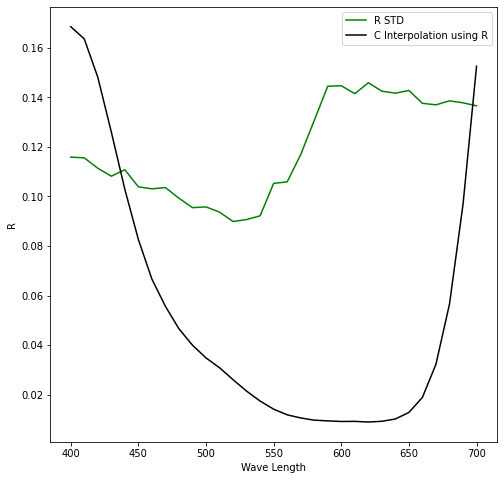

[0.81930826 0.11061396 0.00389214]
0.32398518021051004


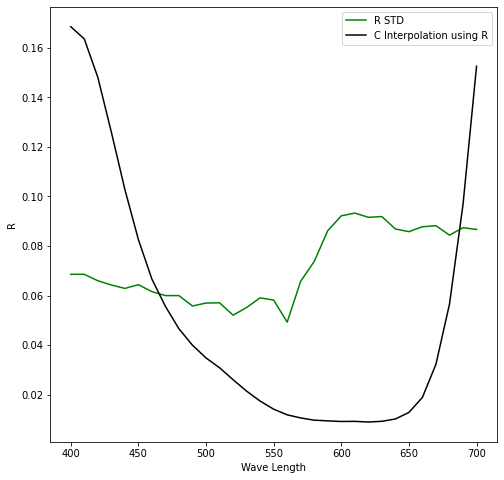

[0.77293164 0.13815344 0.14709053]
0.23080480359029804


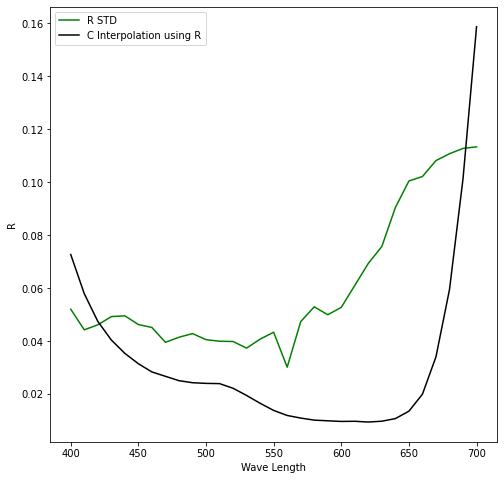

[0.010425   0.04088732 0.02167504]
1.7190121457997332


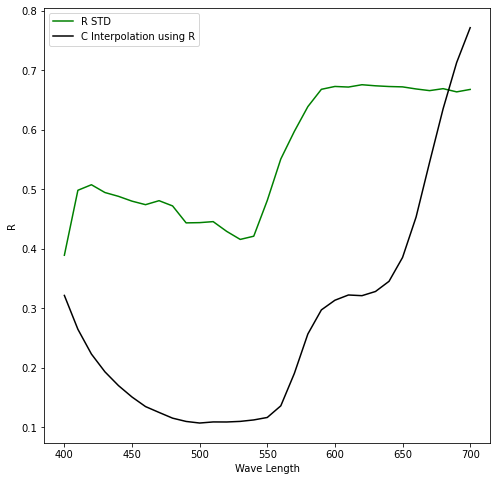

[0.03724134 0.04006808 0.02255367]
1.3729001208014944


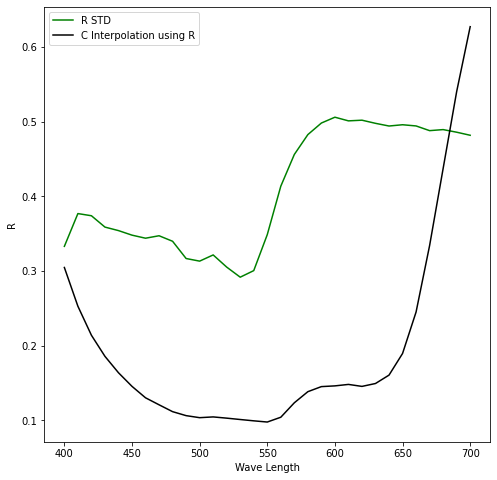

In [11]:
# Number of points
pr = 10

# Number of times to reduce dimension
dim = 3  # 3D

Dis1 = np.linspace(0, 1, pr)
Dis2 = np.linspace(0, 1, pr)
Dis3 = np.linspace(0, 1, pr)

R_Lookup = []
C_Lookup = []

Mix = Mixture(R_sub)
for x in range(pr):
    for y in range(pr):
        for z in range(pr):
            Mix.clear()
            Mix.add(Dis1[x], blue_KOVERS)
            Mix.add(Dis2[y], red_KOVERS)
            Mix.add(Dis3[z], yellow_KOVERS)
            R_Lookup.append(Mix.getR().T[0])
            C_Lookup.append([Dis1[x], Dis2[y], Dis3[z]])

R_Lookup = R_Lookup
R_Lookup = np.array(R_Lookup)
R_Lookup = mm.array_PC(R_Lookup, dim, eigenVectors)
# print(R_Lookup.shape)

C_Lookup = np.array(C_Lookup)
calc = MyDelaunay(R_Lookup, "Qt")

for i in range(10):
    # Changing R_std
    R_std = np.array([munsell_R.T[i]]).T

    # Finding
    R_Find = R_std.T[0]
    R_Find = mm.PC(R_Find, dim, eigenVectors)
    try:
        res = calc.getResult(R_Find, C_Lookup)
    except Exception:
        C_Inter2 = np.array([0, 0, 0])

    C_Inter2 = res[0]

    Mix.clear()
    Mix.add(C_Inter2[0], blue_KOVERS)
    Mix.add(C_Inter2[1], red_KOVERS)
    Mix.add(C_Inter2[2], yellow_KOVERS)
    R_Inter2 = Mix.getR()
    Inter2 = Observation(light_source, viewer, Mix.getR())
    STD = Observation(light_source, viewer, R_std)
    compare_4 = Compare(Inter2, STD)
    RMS_Inter2 = compare_4.RMS()
    DeltaE_Inter2 = compare_4.delta_E()

    print(C_Inter2)
    print(RMS_Inter2)

    (p1,) = plt.plot(wave_length, R_std, color="green", label="R STD")
    (p2,) = plt.plot(
        wave_length, R_Inter2, color="black", label="C Interpolation using R"
    )
    lines = [p1, p2]
    plt.legend(lines, [l.get_label() for l in lines])
    plt.gcf().canvas.set_window_title("Comparison")
    plt.xlabel("Wave Length")
    plt.ylabel("R")
    plt.gcf().set_size_inches(8, 8)
    plt.show()